# Knowledge Graph

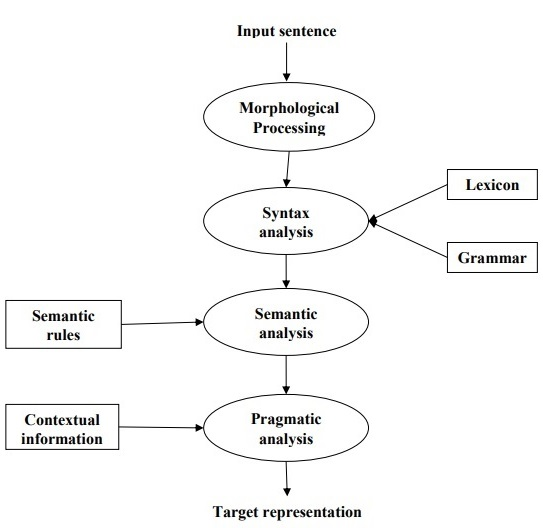

In [5]:
#Following diagram shows the phases or logical steps in natural language processing 
from IPython.display import Image
Image("phases_or_logical_steps.jpg")

In [ ]:
kaggle kernels output pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk -p /path/to/dest

1. Introduction
1.1 What is Knowledge Graph?
A knowledge graph is a way of storing data that resulted from an information extraction task. Many basic implementations of knowledge graphs make use of a concept we call triple, that is a set of three items(a subject, a predicate and an object) that we can use to store information about something.

In [1]:
import re
import pandas as pd
import bs4
import requests
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy

pd.set_option('display.max_colwidth', 200)


In [2]:
nlp = spacy.load('en_core_web_sm')

In [10]:
candidate_sentence = pd.read_csv('I://NLP/test.csv')

In [13]:
candidate_sentence.sample(15)

,id,tweet
964,8885,@appletweets I am profoundly disgusted with Apple for not warning of dangers of IOS 6. Phone destroyed and documents lost.
1580,9501,"good to be back into my phone but so pissed off that ive lost all my pictures, music and videos:("
1091,9012,#Eminem #hiphop #rap #iphone #music #like #follow #followme @ Wonderland http://instagram.com/p/XZ0KCJJzPB/
44,7965,"Love new @sonyelectronics earphones, enjoying music #Sony #earphone #music #freak… https://instagram.com/p/05CH91xU29/"
420,8341,ReallyReal w #Photobooth for #iphone #ipad #Dating http://reallyreal.com/ #college #sorority #single 3zpic.twitter.com/Hn5Zl8KUTX
5,7926,#Repost @getbakednfried with repostapp ・・・ to announce we will have our #apple #bourbon… https://www.instagram.com/p/BK5okHOgWSS/
316,8237,Love is... #mylife #aliceslider #daughter #mom #mylove #apple#smile #доченька #дочарада… https://instagram.com/p/3ES-ctmJcu/
1822,9743,The Future so bright gotta wear #shades! #profile #iphone #vancouver #Wpshades http://instagr.am/p/MbZiUAOxpB/
17,7938,"10 fucking iPhone chargers && none work, is this a fucking joke?! Thank god my ihome works....for now #apple"
476,8397,Hi selfieeee #shoutouts #indian #malayali #fun #tbt #tbs #tagging #photography #iphone #users… http://instagram.com/p/w9H1DAPAkn/


In [16]:
candidate_sentence.tweet

0                                                                                                                      I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks
1                                                                                currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/
2                                                                                          I'd like to puts some CD-ROMS on my iPad, is that possible?' — Yes, but wouldn't that block the screen?\n
3                                                                  My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing
4                                                                                                                             Been fighting iTunes all night! I only want the music I $&@*# paid for
               

__Sentence Segmentation__
The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object.

In [17]:
doc = nlp("the drawdown process is governed by astm standard d823")

In [18]:
for tok in doc:
    print(tok.text, "...",tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


__Entities Extraction__
The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.
1. entity spans across multiple words, then POS tags alone are not sufficient.
2. To build a knowledge graph, the most important things are the nodes and the edges between them.
3. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.


1. Chunk 1

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

2. Chunk 2

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

3. Chunk 3

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

4. Chunk 4

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

5. Chunk 5

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [27]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [29]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [30]:
entity_pairs = []

for i in tqdm(candidate_sentence['tweet']):
    entity_pairs.append(get_entities(i))

100%|██████████████████████████████████████████████████████████████████████████████| 1953/1953 [00:20<00:00, 95.03it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [31]:
entity_pairs

[['# # apple', 'apps'],
 ['', 'apple  iMac'],
 ['that', 'screen'],
 ['officially  I', '1D # hatinglife'],
 ['night  I', 'only  music'],
 ['Repost repostapp we', '#  bourbon'],
 ['Bad  things', 'really  phone'],
 ['BABY #', ''],
 ['why  I', 'minutes  fact'],
 ['#  apple', 'nyc http://ift.tt/1RI7dyo pic.twitter.com/ZuO9tHmEK3'],
 ['mi  buddy#edgar', ''],
 ['MyMomIsGreatBecause  she', '# # tweet'],
 ['kiss,,#romance,#hot,#movie,#iphone,#sex,#porn Lustful Mature Woman',
  'Intensively Mission http://bit.ly/SPBTUR'],
 ['loved  one', '# news ipad'],
 ['New phone case', '#  Flag'],
 ['# Photo #', '6plus  Swarovski'],
 ['mine', 'ME'],
 ['fucking  ihome', 'now # apple'],
 ['I', 'fucking security verifications'],
 ['# Justin #', '# # music'],
 ['', '#  RoseGold'],
 ['', '#  iPhone'],
 ['iPhone screen', 'bed phone falls'],
 ['Samsung', 'SamsungBlast # GalaxyNote7pic.twitter.com/HMWz5fGCMq'],
 ['it', 'iPhone'],
 ['', 'best  #'],
 ['# positivevibes #', '#  vacation'],
 ['# # igers', '# # apple'],
 

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns

1. Relations Extraction
Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.
2. The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [58]:
def get_relation(sent):
    
    doc = nlp(sent)
    
    #mathcer calss obj
#     mather  =Matcher()
    matcher = Matcher(nlp.vocab)
    
    pattern = [{"DEP":"ROOT"},
        {"DEP":"prep","OP":"?"},
        {"DEP":"agent","OP":"?"},
        {"POS":"ADJ","OP":"?"}]
    
    matcher.add( "matching_1",[pattern])
    
    matches  =matcher(doc)
    
    k = len(matches) - 1
    
    span = doc[matches[k][1]:matches[k][2]]
    
    return (span.text)

In [59]:
get_relation("John completed the task")

'completed'

In [60]:
relations = [get_relation(i) for i in tqdm(candidate_sentence.tweet)]

100%|█████████████████████████████████████████████████████████████████████████████| 1953/1953 [00:19<00:00, 102.40it/s]


In [61]:
relations

['sucks',
 'cashmoney',
 'Yes',
 'lost',
 'want',
 '@getbakednfried with',
 'apple',
 'apple',
 'waiting',
 'fruit',
 'taller',
 'do',
 'Nailed',
 'fail',
 'GalaxyS3 #British',
 'https://instagram.com/p/3UbQKNoL6-/',
 'cute',
 'Thank',
 'buy',
 'android',
 '#new',
 'Got',
 'CRACKED',
 'stops',
 'hateitunes',
 'one of',
 'cool',
 'explore',
 'lame',
 'smile',
 'remember',
 'be',
 'zandzuigerpic.twitter.com/DDrVJKvGrM',
 'verygood',
 'FOLLOW',
 'apple',
 'hate',
 'FOLLOW',
 'Exits',
 'http://instagram.com/p/xcp9Zor6W9/',
 'android',
 'Check',
 'love',
 'see',
 'Love new',
 'snack',
 'growing strong',
 'http://dlvr.it/5PJzxv',
 'got',
 'thisaintright',
 'spent',
 'http://greenrobot-apps.net/3607-heavenstrike-rivals-izuchi-boevuyu-sistemu.html',
 'keep',
 'FOLLOW',
 'waiting for',
 'felt',
 'Idiot',
 'anscestors',
 'smallbiz #',
 'happen',
 'As',
 'M',
 'new',
 'igers',
 'LoveMatcher',
 'intagram',
 'droid',
 'hope',
 'create',
 'fact',
 'nike',
 'http://instagram.com/p/iWPlsOkqSG/',
 'had

In [63]:
pd.Series(relations).value_counts()[:50]

apple         60
is            38
#             37
FOLLOW        35
iphone        25
have          25
Make          24
smile         17
's            15
fail          15
cute          14
love          14
Check         12
iPhone        11
hate          10
got           10
follow         9
be             8
had            8
Follow         8
sales #        8
android        8
Love           7
gratitude      7
want           7
know           7
iphone4        6
buy            6
Apple          6
samsung        6
Is             6
Photo          6
are            6
galaxy         5
Keep           5
'm             5
Get FREE       5
Samsung        5
Get            5
was            4
headphones     4
makes          4
fun            4
am             4
Watch          4
fuck           4
found          4
deleted        4
laugh          4
change         4
dtype: int64

1. Build Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [65]:
#extract subj
source = [i[0] for i in entity_pairs]

In [66]:
#extarct obj
target = [i[1] for i in entity_pairs]

In [67]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [69]:
#create directed graph
G = nx.from_pandas_edgelist(kg_df, "source","target",edge_attr=True, create_using=nx.MultiDiGraph())

C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 58378 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 1042435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 1042452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50556 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51032 missing from current font.
 

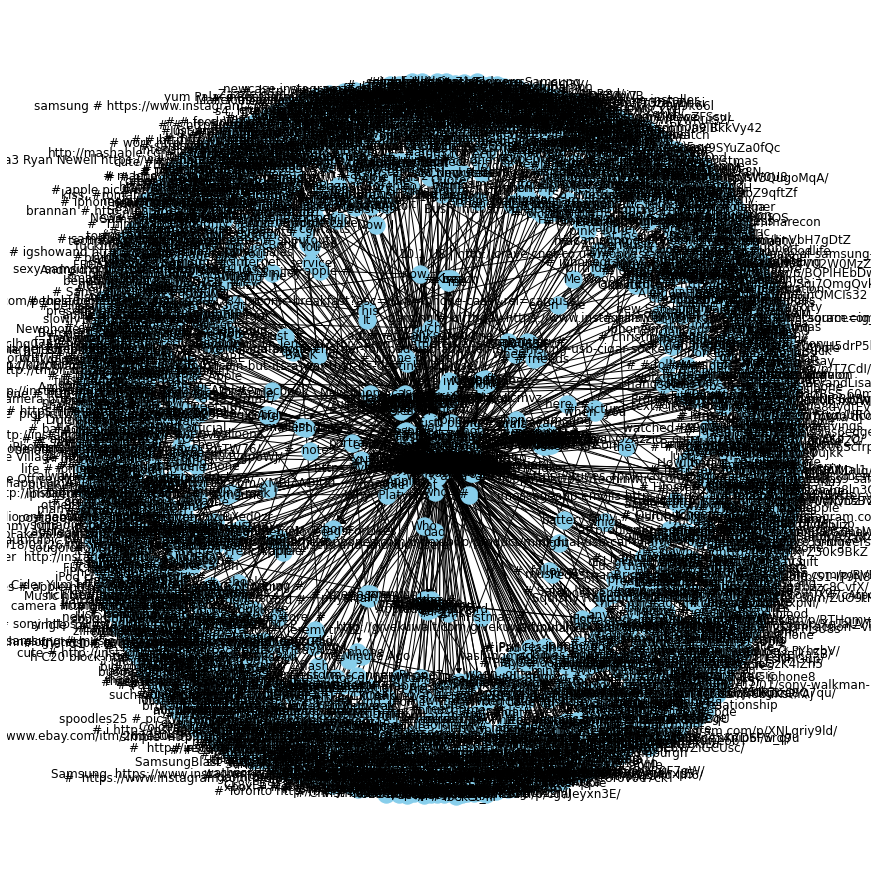

In [70]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.



In [95]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "iphone"],"source","target",
                           edge_attr=True, create_using=nx.MultiDiGraph())

C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 58382 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 58382 missing from current font.
  font.set_text(s, 0, flags=flags)


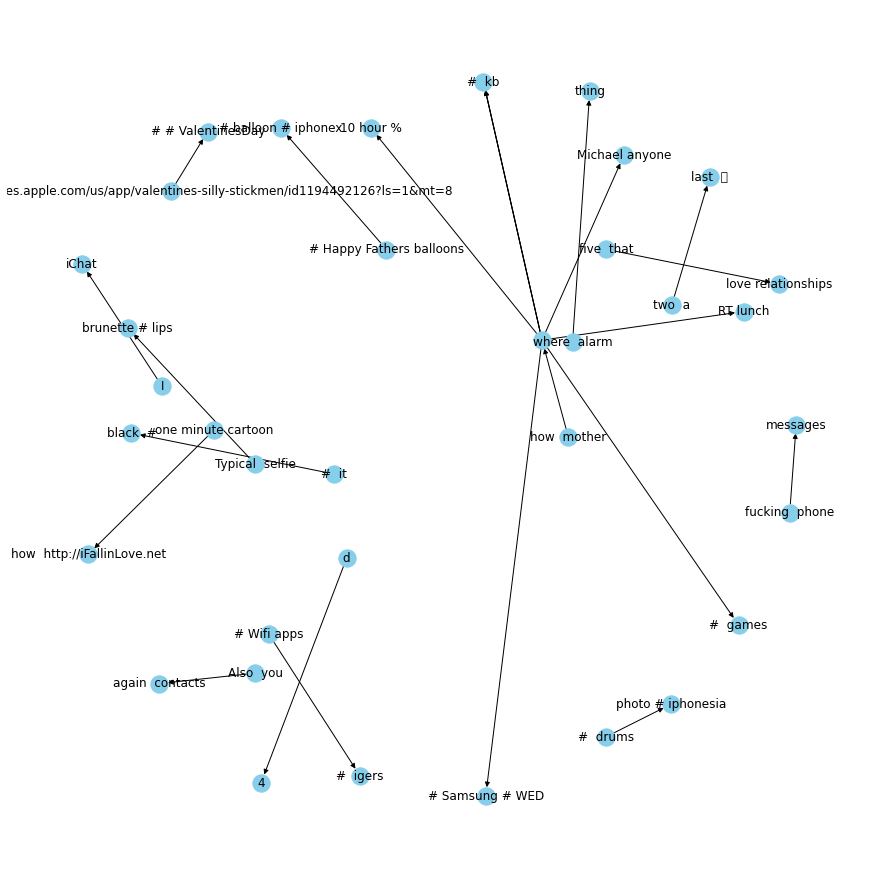

In [96]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G,k=0.5) # k regulates the distance between nodes
#nx.draw(G,with_labels = True, node_color = '#3991c6', edge_cmap = plt.cm.Blues, pos = pos)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

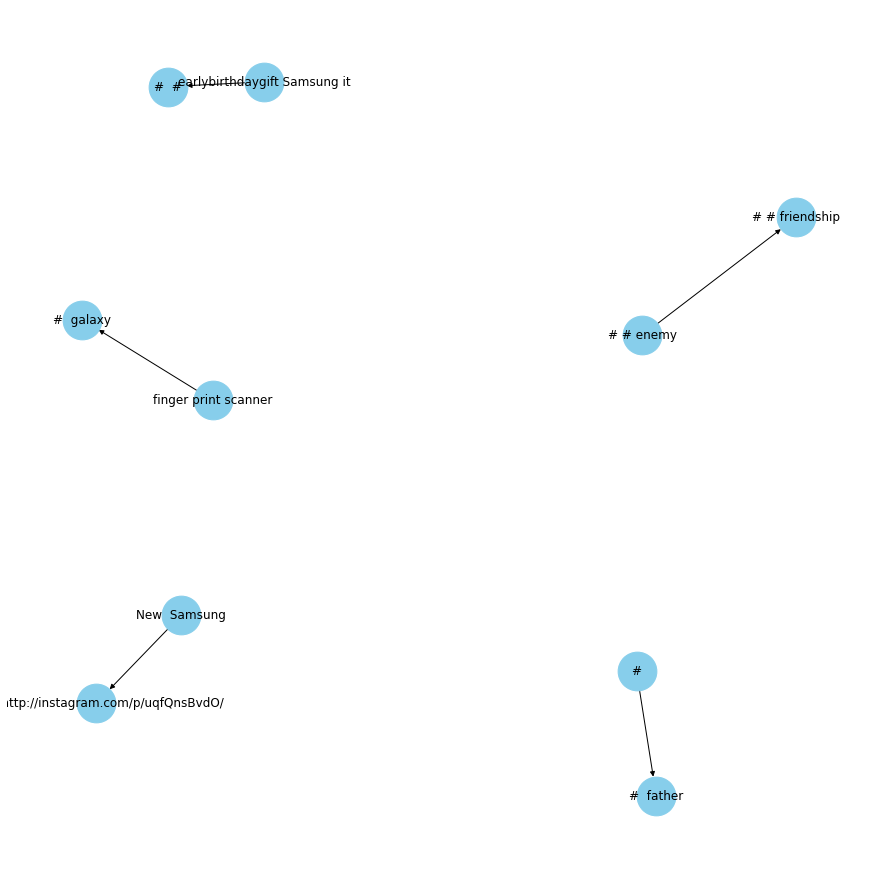

In [105]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="galaxy"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [104]:
kg_df

,source,target,edge
0,# # apple,apps,sucks
1,,apple iMac,cashmoney
2,that,screen,Yes
3,officially I,1D # hatinglife,lost
4,night I,only music,want
...,...,...,...
1948,,# Year Samsung,http://gizmodo.com/samsung-galaxy-note-7-explodes-burns-6-year-old-repor-1786523345
1949,,# Available discount,Check
1950,durable that,Apple,be great
1951,time we,well # apple,@codeofinterest


# BERT

At the end of 2018 researchers at Google AI Language open-sourced a new technique for Natural Language Processing (NLP) called BERT (Bidirectional Encoder Representations from Transformers) — a major breakthrough which took the Deep Learning community by storm because of its incredible performance.

BERT stands for __Bidirectional Encoder Representations from Transformers__. Let us understand this in detail each word .

1. Bidirectional - to understand the text you’re looking you’ll have to look back (at the previous words) and forward (at the next words)
2. Transformers - The Attention Is All You Need paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. his in a sentence refers to Jim).
3. (Pre-trained) contextualized word embeddings - The ELMO paper introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.
BERT was trained by masking 15% of the tokens with the goal to guess them

1. Architecture
The original BERT model was developed and trained by Google using TensorFlow. BERT is released in two sizes __BERTBASE__ and __BERTLARGE__.

1. BERT is basically an Encoder stack of transformer architecture. A transformer architecture is an encoder-decoder network that uses self-attention on the encoder side and attention on the decoder side.

2. __BERTBASE has 12 layers__ in the Encoder stack while __BERTLARGE has 24 layers__ in the Encoder stack. These are more than the Transformer architecture described in the original paper (6 encoder layers).
- BERT-Base: 12 layer Encoder / Decoder, d = 768, 110M parameters
- BERT-Large: 24 layer Encoder / Decoder, d = 1024, 340M parameters

1. main benefits of using BERT:
- Easy Training
- Less Data
- Good Results
- A Shift in NLP

- What is language modeling really about? Which problem are language models trying to solve? Basically, their task is to “fill in the blank” based on context.
- In the pre-BERT world, a language model would have looked at this text sequence during training from either left-to-right or combined left-to-right and right-to-left. This one-directional approach works well for generating sentences 

* BERT is pre-trained on two NLP tasks:
1. Masked Language Modeling (MLM)
- Let’s say we have a sentence – “I love to read data science blogs on Kaggle”. We want to train a bi-directional language model. Instead of trying to predict the next word in the sequence, we can build a model to predict a missing word from within the sequence itself.
 - Let’s replace “Kaggle” with “[MASK]”. This is a token to denote that the token is missing. We’ll then train the model in such a way that it should be able to predict “Kaggle” as the missing token: “I love to read data science blogs on [MASK].”
 - To prevent the model from focusing too much on a particular position or tokens that are masked, the researchers randomly masked 15% of the words.

 - The masked words were not always replaced by the masked tokens [MASK] because the [MASK] token would never appear during fine-tuning.
 
2. Next Sentence Prediction (NSP)
 - BERT is then required to predict whether the second sentence is random or not, with the assumption that the random sentence will be disconnected from the first sentence:

When can we use it?
 - Natural Language Inference
 - Sentiment Analysis
 - Question Answering
 - Paraphrase detection
 - Linguistic Acceptability
 

## Use Case - Text Classification using BERT